In [1]:
'''
Analyze displacement measurement using laser displacement sensor 
Author: Yitian Shao
Created on 2022.10.17 based on 'NanoForceAnalysis'
'''

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import mlab
import pandas as pd
import scipy.io as scio
from scipy import signal
import seaborn as sns
from IPython.core.display import HTML

plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rcParams['lines.linewidth'] = 1.125
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['errorbar.capsize'] = 4

figSize_inch = (3.2, 2.4)

''' Define Color Here '''
pltBlue = (32/255,120/255,180/255)
pltGreen = (32/255,180/255,120/255)
pltRed = (180/255,32/255,32/255)
pltYellow = (120/255,120/255,32/255)

'''  Color used in the paper '''
pBlue = (32/255,120/255,180/255)
pRed = (185/255,49/255,49/255)
pGrey = (77/255,77/255,77/255)

''' Remove warnings '''
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
General Functions
'''

def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeData(fileName, numFormat, frontCode='', rearCode=''):
    segStr = re.findall(frontCode+numFormat+rearCode, fileName)
    if segStr:
        numData = float(re.findall(numFormat, segStr[0])[0])
    else:
        numData = None
    return numData

def cutRepeatTrial(rawData, Fs, expectedTrialNum, disp=False): 
    smData = lowpassSmooth(rawData, cutFreqRatio = (10/Fs), order = 8)
    
    smData = smData - smData[0]
    
#     smData = signal.detrend(smData, type='linear')
    
    samp = np.arange(len(rawData))
    
    maxRawValue = np.max(smData)
    
    ''' Fine tunning needed for individual measurement session'''
    segPointInd = np.squeeze(np.argwhere(smData[10:] > 0.25 * maxRawValue)) # Find value larger than 25% of peak as valid segment data point
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > 1))# Index of point where large gap occurs (end and start of a seg)
    cutInd = (0.5 * (segPointInd[segGapInd] + segPointInd[segGapInd+1])).astype(int) # Cut in the middle of a end and a start point
    
    if not isinstance(cutInd,np.ndarray) or len(cutInd) < expectedTrialNum-1:
        if disp:
            ax0, _ = aPlot(); 
            ax0.plot(samp, rawData, color='k'); 
            plt.show();       
        return []
    
    if len(cutInd) > expectedTrialNum-1:
        cutInd = cutInd[:expectedTrialNum]
    elif len(cutInd) == expectedTrialNum-1:
        cutInd = np.insert(cutInd, expectedTrialNum-1, len(rawData)-1)

    avgSegLen = np.mean(np.diff(cutInd))
    cutInd = np.insert(cutInd, 0, max(cutInd[0]-avgSegLen, 0))
    
    if disp:
        ax0, _ = aPlot(); 
        ax0.plot(samp, rawData, color='k'); 
        ax0.plot(samp, smData, color='tab:blue')
        ax0.plot(cutInd, np.zeros(cutInd.shape), '*r')
        plt.show();
    
    return cutInd

def getDataArray(dFrame, indList, colName, toFlat=False):
    compValue = (dFrame.loc[indList,colName]).to_numpy()  
    
    if toFlat:
        flatValue = []
        for aRow in compValue:
            flatValue.extend(aRow)
        flatValue = np.array(flatValue)
        return flatValue
            
    return compValue
    
def getMeanSTD(compValue): # Compute errorbar of data mixing all conditions (rows of input array)
    if len(compValue) == 0:
        return None, None
        
    compValue = np.array(compValue)
    
    meanValue = np.mean(compValue)
    stdValue = np.std(compValue)
    
    return meanValue, stdValue

In [3]:
'''
Load, preprocess and segment displacement data
'''
def dataVibSegmentation(measureDataPath):
    # Vibrometer data format
    VibrometerHeadRowIndex = 3
    TimeLabel = '[ s ]'
    VibDisplacementLabel = '[ m ]' # Note that vibrometer measurement unit is 'm' instead of 'mm' and requires unit conversion!

    Fs = None 

    laserData = []

    ''' Data preprocess and segmentation '''
    for root, directories, files in walk(measureDataPath):
        for fileName in files:
            tubeLen = decodeData(fileName, '[\d+\.]*\d+', rearCode='mm')
            infillVol = decodeData(fileName, '[\d+\.]*\d+', rearCode='mL') 
            sinFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='Hz') 
            voltage = decodeData(fileName, '[\d+\.]*\d+', rearCode='kV') 

            trialNum = decodeData(fileName, '\d+', rearCode='.txt')
            if trialNum is None:
                trialNum = 1

            dLabel = ""
            if tubeLen is not None:
                dLabel = dLabel + ("%.1fmm" % tubeLen)    
            if infillVol is not None:
                dLabel = dLabel + ("%.2fmL" % infillVol)           
            if sinFreq is not None:
                dLabel = dLabel + ("%.1fHz" % sinFreq)
            if voltage is not None:
                dLabel = dLabel + ("%.1fkV" % voltage)

            print("%s - trial%s" % (dLabel, trialNum))

            metaData = pd.read_csv(ospa.join(root, fileName), header=None, nrows=VibrometerHeadRowIndex, sep='\t')
    #         display(HTML(metaData.to_html(index=False, header=None)))
            readData = pd.read_csv(ospa.join(root, fileName), header = VibrometerHeadRowIndex, sep='\t')

            if readData is not None:
                t = readData[TimeLabel].to_numpy(dtype='float64')
                vibDispl = readData[VibDisplacementLabel].to_numpy(dtype='float64')

                diffT = np.diff(t)
                diffT = diffT[diffT > 0]
                SampleRate = int(1.0/np.mean(diffT))
                if SampleRate != Fs:
                    if Fs is None:
                        Fs = SampleRate
                        print("Sampling frequenecy = %.2f Hz" % Fs)
                    else:
                        print("Sampling frequenecy of current data %.2fHz differs from the Fs = %.2f Hz" % (SampleRate, Fs))
                        Fs = SampleRate
                
                vibDispl = vibDispl*1e3 # Convert unit from 'm' to 'mm' for vibrometer measurements
#                 print("Range from %f to %f" % (np.min(vibDispl),np.max(vibDispl)))
                
                data = []

                if re.findall('Frequency', measureDataPath): # No data segmentation is needed for frequency response test
                        data.append(vibDispl)

                laserData.append([dLabel, tubeLen, sinFreq, voltage, trialNum, data])

#                 fig,ax = plt.subplots(dpi=72, figsize=(14,4))
#                 fig.suptitle("%s" % (dLabel))
#                 ax.plot(t, vibDispl, color='tab:blue')

    laserData = pd.DataFrame(laserData, columns = ['Label', 'TubeLength_mm', 'SinFreq_Hz', 'Voltage_kV','Trial','Data'])  

    display(laserData.head(10))
    display(laserData.tail(10))
    
    return laserData, Fs

''' (Outdated) data segmentation for laser displacement sensor '''
def dataSegmentation(measureDataPath):

    Fs = None 

    laserData = []

    ''' Data preprocess and segmentation '''
    for root, directories, files in walk(measureDataPath):
        for fileName in files:
            measureDate = decodeData(fileName, '\d{4}', rearCode='2022')
            tubeLen = decodeData(fileName, '[\d+\.]*\d+', rearCode='mm')
            infillVol = decodeData(fileName, '[\d+\.]*\d+', rearCode='mL') 
            pulseFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='mHz')  

            sinFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='Hz') 
            voltage = decodeData(fileName, '[\d+\.]*\d+', rearCode='kV') 

            trialNum = decodeData(fileName, '\d+', rearCode='.txt') # DispData20221017
            if trialNum is None:
                trialNum = 1

            dLabel = ""
            if tubeLen is not None:
                dLabel = dLabel + ("%.1fmm" % tubeLen)    
            if infillVol is not None:
                dLabel = dLabel + ("%.2fmL" % infillVol)           
            if sinFreq is not None:
                dLabel = dLabel + ("%.1fHz" % sinFreq)
            if voltage is not None:
                dLabel = dLabel + ("%.1fkV" % voltage)

            print("%s - trial%s" % (dLabel, trialNum))

            readData = pd.read_csv(ospa.join(root, fileName), header = None)

            if readData is not None:       
                t = readData[0].to_numpy()
                diffT = np.diff(t)
                diffT = diffT[diffT > 0]
                SampleRate = int(1.0/np.mean(diffT))
                if SampleRate != Fs:
                    if Fs is None:
                        Fs = SampleRate
                        print("Sampling frequenecy = %.2f Hz" % Fs)
                    else:
                        print("Sampling frequenecy of current data %.2fHz differs from the Fs = %.2f Hz" % (SampleRate, Fs))
                        Fs = SampleRate

                v = readData[1].to_numpy()
                dispData = readData[2].to_numpy()
                
#                 print("Range from %f to %f" % (np.min(dispData),np.max(dispData)))

                data = []

                if re.findall('Frequency', measureDataPath): # No data segmentation is needed for frequency response test
                    data.append(dispData)  
                else:
                    cutInd = cutRepeatTrial(dispData, Fs, 6, disp=True)
                    segNum = len(cutInd)-1

                    if segNum < 0:
                        cutInd = cutRepeatTrial(dispData, Fs, 5, disp=True)
                        segNum = len(cutInd)-1

                    if segNum > 0: 
                        for j in range(segNum):
                            segData = dispData[cutInd[j]:cutInd[j+1]]
                            data.append(segData)  

                laserData.append([dLabel, tubeLen, sinFreq, voltage, trialNum, data])
                
#                 fig,ax = plt.subplots(dpi=72, figsize=(14,4))
#                 fig.suptitle("%s" % (dLabel))
#                 ax.plot(dispData, color='tab:blue')

    laserData = pd.DataFrame(laserData, columns = ['Label', 'TubeLength_mm', 'SinFreq_Hz', 'Voltage_kV','Trial','Data'])  

    display(laserData.head(10))
    display(laserData.tail(10))
    
    return laserData, Fs

# measureDataPath = './DispData20221017Voltage_old60mmand110mm' # (Obsoleted)
# measureDataPath = './DispData20221017Frequency' # 110mm

In [ ]:
'''(Exclusive) Frequency response characteristics for the actuator (2024 Feb - Vibrometer measurement)'''
measureDataPath = './VibrometerData20240313Frequency' # 110mm measured on 2024.03.13 with vibrometer (0229)
laserData, Fs = dataVibSegmentation(measureDataPath)

'''(Exclusive) Frequency response characteristics for the actuator (Outdated - incapable laser displacement sensor)'''
# measureDataPath = './DispData20221212Frequency' # 60mm and 110mm
# measureDataPath = './DispData20240313Frequency' # 110mm measured on 2024.03.13 with displ. sensor
# laserData, Fs = dataSegmentation(measureDataPath)

labels = laserData.Label.unique()

# labels = ['60.0mm0.4Hz7.0kV','60.0mm0.6Hz7.0kV', '60.0mm1.6Hz7.0kV', '60.0mm10.0Hz7.0kV',
#  '60.0mm12.6Hz7.0kV', '60.0mm1.0Hz7.0kV', '60.0mm2.5Hz7.0kV',
#  '60.0mm2.0Hz7.0kV', '60.0mm3.2Hz7.0kV', '60.0mm4.0Hz7.0kV',
#  '60.0mm5.0Hz7.0kV', '60.0mm6.3Hz7.0kV', '60.0mm7.9Hz7.0kV']; # Fs = 98
# print(labels) 

dataFeature = []

concateSignal = np.empty([0, 1], dtype=float)

for aLabel in labels:
    selectedData = laserData.loc[(laserData['Label'] == aLabel)]
    
    freqMag = []
    
    for index, row in selectedData.iterrows():
        for aSignal in row["Data"]:           
            y = aSignal
            y = y - np.amin(y)
            
            # data processing to remove the inital overshooting
            truncStart = np.argmax(y > (0.5*np.max(y)))+500
            truncEnd = int(10*Fs) + truncStart # Truncate only 10 seconds of measurement
            y = y[truncStart:truncEnd]
            
            y = y - np.amin(y)
            
            RMSdispl= 2*np.sqrt(np.mean((y - np.mean(y))**2))
            
            concateSignal = np.append(concateSignal, y)
            
            _, ax1 = plt.subplots(1,2, dpi=72, figsize=(12,2))
            ax1[0].plot((np.arange(len(y))/Fs),y, 'k')
            ax1[0].set_xlabel('Time (s)')
            ax1[0].set_ylabel('Displacement (mm)')
            ax1[0].set_title('RMS Displ. = %.6f mm' % RMSdispl)
#             ax1[0].set_xlim([5, 5.2]) # Zoom in to investigate the black out issue
            
            spectr, f, _ = ax1[1].magnitude_spectrum(y, Fs=Fs, color='C1', window=mlab.window_none)
            
            ind = np.argwhere(f < 0.3)
            spectr[ind] = 0
            
            ''' (Updated 2024.02.29) Force to search peak near the desired frequency '''
            searchInd = np.argwhere((f > row['SinFreq_Hz']-10) & (f < row['SinFreq_Hz']+10))
            
            idx = spectr.argmax()
            if len(searchInd)>0:           
                idx = spectr[searchInd].argmax() + searchInd[0] 
            else:
                print("Cannot find a peak around frequency of %.1f Hz" % row['SinFreq_Hz'])
            
            freqMagValue = spectr[idx]
#             avgFInd = 2
#             freqMagValue = np.max(spectr[idx-avgFInd:idx+avgFInd])
#             print("Mean magnitude from frequency %.2f - %.2f Hz - %.2f" % (f[idx-avgFInd], f[idx+avgFInd],freqMagValue))
            
            actualPeakFreq = f[idx]
            
            print("Desired sin frequency = %.2f Hz - Actually frequency = %.2f Hz" % (row['SinFreq_Hz'], actualPeakFreq))
            
            if abs(row['SinFreq_Hz'] - actualPeakFreq) > 10:
                print("failed")
                freqMagValue = np.float64(1e-9)

            ax1[1].plot(actualPeakFreq, freqMagValue, '.b')    
            ax1[1].set_xlim([0.1, Fs/2])
            ax1[1].set_ylabel("Magnitude")
            ax1[1].set_title(row['Label'])
            
            freqMag.append(freqMagValue)
            
    dataFeature.append([aLabel, row["TubeLength_mm"], row['SinFreq_Hz'], freqMag])

dataFeature = pd.DataFrame(dataFeature, columns = ['Label', 'TubeLength_mm','SinFreq_Hz','FreqMag'])  

display(dataFeature.head(10))
# display(dataFeature.tail(10))
display(dataFeature['SinFreq_Hz'])

In [ ]:
'''(Exclusive) Produce frequency response plot'''
def freqResponse(dframe, dispFrequencies, yColName, yColSelect):
    dispFreqMag = []
    for aFreq in dispFrequencies:
        freqMag = dframe.loc[(dframe['SinFreq_Hz'] == aFreq) & (dframe[yColName] == yColSelect), 'FreqMag']
        if len(freqMag) == 0:
            print("Failed: %f Hz" % aFreq)
            dispFreqMag.append(1e-9)
        else:
            freqMag = freqMag.values[0][0].tolist()
            dispFreqMag.append(freqMag)

    dispFreqMag = np.array(dispFreqMag)

    dispLogMag = 20*np.log10(dispFreqMag)
    
    logMagZero = 20*np.log10(0.25) # Define 1mm peak-to-peak displacement as 0dB
    
    dispLogMag = dispLogMag-logMagZero
    
    return dispLogMag, dispFreqMag * 4 # (dB, mm)

# octaveFrequencies = [4.000e-01, 6.000e-01, 1.000e+00, 1.600e+00, 2.000e+00, 2.500e+00, 3.200e+00,
#                      4.000e+00, 5.000e+00, 6.300e+00, 7.900e+00, 1.000e+01, 1.260e+01, 1.580e+01,
#                      2.000e+01, 2.510e+01, 3.160e+01, 3.98e+01, 5.010e+01, 6.310e+01, 7.940e+01,
#                      1.000e+02, 1.259e+02, 1.585e+02, 1.995e+02, 2.512e+02, 3.162e+02, 3.981e+02,
#                      5.002e+02] 
octaveFrequencies = [4.000e-01, 6.000e-01, 1.000e+00, 1.600e+00, 2.000e+00, 2.500e+00, 3.200e+00,
                     4.000e+00, 5.000e+00, 6.300e+00, 7.900e+00, 1.000e+01, 2.0e+01, 5.0e+01] 

dispFrequencies = [0.4, 1, 2, 4, 10, 20, 40, 100, 200, 500]

dispLogMag110, mag110 = freqResponse(dataFeature, octaveFrequencies, 'TubeLength_mm', 110)
x110 = np.log10(octaveFrequencies)

# dispLogMag60, mag60 = freqResponse(dataFeature, octaveFrequencies, 'TubeLength_mm', 60)

xTicks = np.log10(dispFrequencies)
xLabel = 'Frequency (Hz)'

colors = sns.color_palette('hls', n_colors=3)
# colors = sns.light_palette(pltRed, reverse=True, n_colors=(5+8))

fig1, ax1 = plt.subplots(dpi=300, figsize=(5,1))

ax1.plot([x110[0], x110[-1]], [0, 0], '--', c='0.5')

# ax1.plot(x110, dispLogMag60, '.-', c=colors[1])
ax1.plot(x110, dispLogMag110, '.-', c=colors[0])
ax1.set_ylabel('Magnitude (dB)')

ax1.set_xlabel(xLabel)
ax1.set_xticks(xTicks);
ax1.set_xticklabels(dispFrequencies);

ax1.legend(labels=['1.0mm', '60mm', '110mm'], frameon=False, bbox_to_anchor=(0.0, 2.0), loc='upper left');
ax1.set_yticks([-160, -80, -20, 0])
# ax1.set_ylim([-42, 22])

# fig1.savefig("freq_response_displ_60and110.pdf", bbox_inches='tight')

# '''Average of actuator 60 and 110mm'''
# freqNum = len(octaveFrequencies)
# avgSpectrLogMag = np.zeros((freqNum, ))
# avgFreqMag = np.zeros((freqNum, ))
# for i in range(freqNum):
#     avgSpectrLogMag[i] = np.mean([dispLogMag60[i], dispLogMag110[i]])
#     avgFreqMag[i] = np.mean([mag60[i], mag110[i]])

# print("\n ----- Data (n=12, 110mm) ----- Magnitude (dB) -----")
# print(dispLogMag110)
# print("\n ----- Mixed data for Frequency response ----- ")
# print("Magnitude (dB)")
# print(avgSpectrLogMag)
# print("Absolute displacement (mm)")
# print(avgFreqMag)
# print("Mean - 0.4 Hz to 10 Hz = %.1f mm" % np.mean(avgFreqMag[:12]))
# print("Mean - 10 Hz to 40 Hz = %.1f mm" % np.mean(avgFreqMag[12:18]))
# print("Mean - 40 Hz to 100 Hz = %.1f mm" % np.mean(avgFreqMag[18:22]))
# print("Mean - 100 Hz to 500 Hz = %.1f mm" % np.mean(avgFreqMag[22:]))

validInd = (dispLogMag110 > -60) # Stop plotting if magnitude is below -60 dB

colors = sns.light_palette(pltRed, reverse=True, n_colors=(5+8))

# fig2, ax2 = plt.subplots(dpi=300, figsize=(5,3))    
fig2, ax2 = plt.subplots(dpi=300, figsize=(5,1.5))  
ax2.plot([x110[0], x110[-1]], [0, 0], '--', c='0.5')
# ax2.plot(x110[validInd], dispLogMag110[validInd], '.-', c=colors[0])   ###ax2.plot(x110, avgSpectrLogMag, '.--', c=colors[0])
ax2.plot(x110, dispLogMag110, '.-', c=colors[0])
ax2.set_ylabel('Displacement Magnitude (dB re 1mm peak)')
ax2.set_xlabel(xLabel)
ax2.set_xticks(xTicks);
ax2.set_xticklabels(dispFrequencies);
# ax2.set_yticks([-40, -20, 0])
ax2.set_yticks([-60, -40, -20, 0, 20])
ax2.set_ylim([-60, 20])

In [ ]:
''' Plot detection threshold of human finger '''

externalDataFreqs = np.array([0.4006, 0.5053, 0.7050, 1.0038, 1.2160, 1.5183, 2.0347, 3.0467, 4.0828, 5.0980, 7.1130, 10.2297,
    15.3181, 20.5272, 25.6311, 30.7377, 40.7766, 50.9154, 71.0406, 102.1680, 152.9881, 202.9538, 300.8543, 498.3498])
# ind = (externalDataFreqs < 110)
ind = (externalDataFreqs < 510)
# ind = (externalDataFreqs < 75)
xExt = np.log10(externalDataFreqs) 
DBwrt1um = np.array([26.7498, 27.4045, 27.4045, 26.3133, 26.9680, 28.2775, 28.2775, 27.1863, 23.9127, 24.5674, 21.5121, 19.9844, 
            16.9291, 14.9649, 12.3461, 14.0920, 8.8542, 7.9813, 2.3071, -2.0577, -11.0055, -15.5885, -17.3344, -15.8067])
DBwrt1mm = DBwrt1um - 60 # 1mm = 1000um (20*log10(1000))

ax2.plot(xExt[ind], DBwrt1mm[ind], '.-', c='0.5')
ax2.set_yticks([-100, -80, -60, -40, -20, 0, 20])

# ax2.set_xlim([xExt[ind][0]-0.1, xExt[ind][-1]+0.1])
ax2.set_ylim([-60, 20])

display(fig2)

fig2.savefig("freq_response_displ_110mm.pdf", bbox_inches='tight')

110.0mm3.0kV - trial1.0
Sampling frequenecy = 98.00 Hz


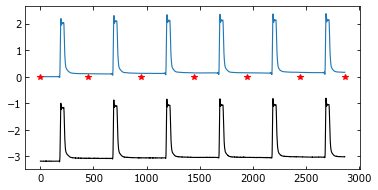

110.0mm3.0kV - trial2.0


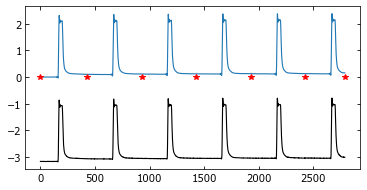

110.0mm4.0kV - trial1.0


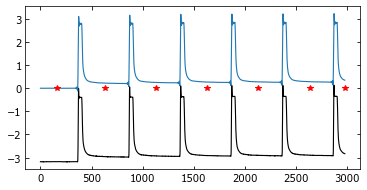

110.0mm4.0kV - trial2.0


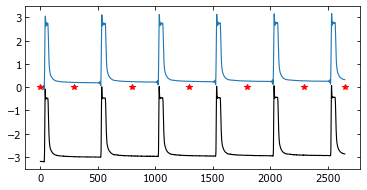

110.0mm5.0kV - trial1.0


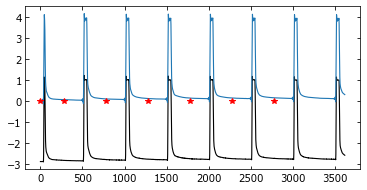

110.0mm5.0kV - trial2.0


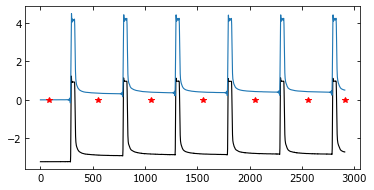

110.0mm6.0kV - trial1.0


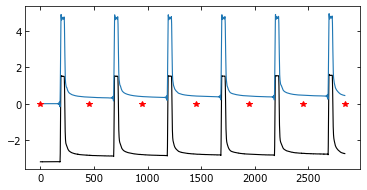

110.0mm6.0kV - trial2.0


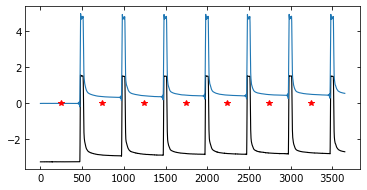

110.0mm7.0kV - trial1.0


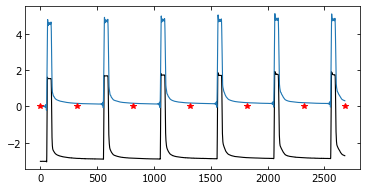

110.0mm7.0kV - trial2.0


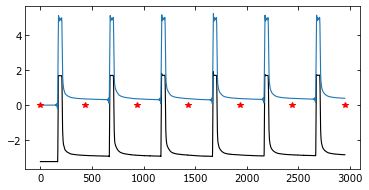

60.0mm3.0kV - trial1.0
Sampling frequenecy of current data 989.00Hz differs from the Fs = 98.00 Hz


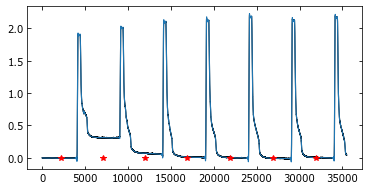

60.0mm3.0kV - trial2.0


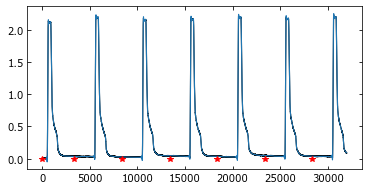

60.0mm4.0kV - trial1.0


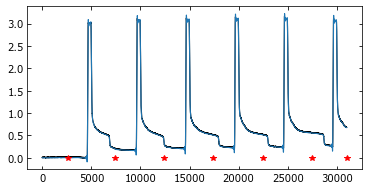

60.0mm4.0kV - trial2.0


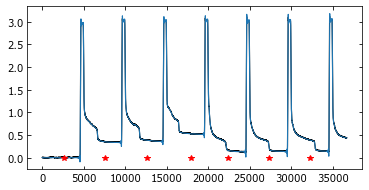

60.0mm5.0kV - trial1.0


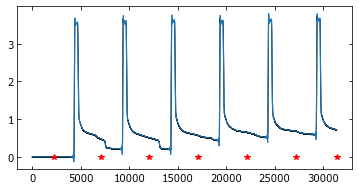

60.0mm5.0kV - trial2.0


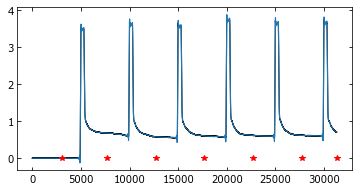

60.0mm6.0kV - trial1.0


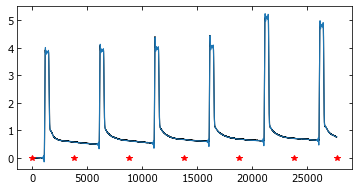

60.0mm6.0kV - trial2.0


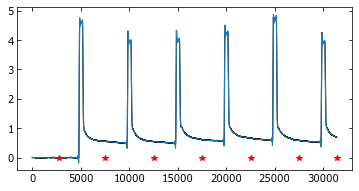

60.0mm7.0kV - trial1.0


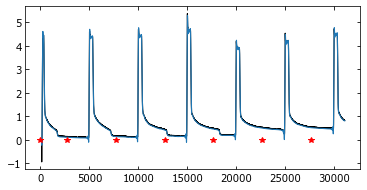

60.0mm7.0kV - trial2.0


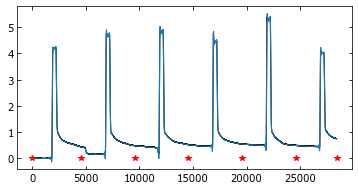

,Label,TubeLength_mm,SinFreq_Hz,Voltage_kV,Trial,Data
0,110.0mm3.0kV,110.0,None,3.0,1.0,"[[-3.1822, -3.1842, -3.1842, -3.1832, -3.1868,..."
1,110.0mm3.0kV,110.0,None,3.0,2.0,"[[-3.1802, -3.1825, -3.1825, -3.1845, -3.1845,..."
2,110.0mm4.0kV,110.0,None,4.0,1.0,"[[-3.1799, -3.1747, -3.1809, -3.1793, -3.177, ..."
3,110.0mm4.0kV,110.0,None,4.0,2.0,"[[-3.196, -3.1957, -3.1954, -3.1954, -3.1957, ..."
4,110.0mm5.0kV,110.0,None,5.0,1.0,"[[-2.9048, -2.9041, -2.9064, -2.9054, -2.9074,..."
5,110.0mm5.0kV,110.0,None,5.0,2.0,"[[-3.2036, -3.2036, -3.2029, -3.2056, -3.2059,..."
6,110.0mm6.0kV,110.0,None,6.0,1.0,"[[-3.177, -3.1773, -3.1737, -3.1763, -3.175, -..."
7,110.0mm6.0kV,110.0,None,6.0,2.0,"[[-3.2361, -3.2391, -3.2388, -3.2391, -3.2407,..."
8,110.0mm7.0kV,110.0,None,7.0,1.0,"[[-3.029, -3.0303, -3.028, -3.03, -3.0287, -3...."
9,110.0mm7.0kV,110.0,None,7.0,2.0,"[[-3.2062, -3.2029, -3.2079, -3.2075, -3.2052,..."


,Label,TubeLength_mm,SinFreq_Hz,Voltage_kV,Trial,Data
10,60.0mm3.0kV,60.0,None,3.0,1.0,"[[-0.0021, -0.0024, -0.0021, -0.0047, -0.0021,..."
11,60.0mm3.0kV,60.0,None,3.0,2.0,"[[0.0009, -0.0011, 0.0006, -0.0011, 0.0009, 0...."
12,60.0mm4.0kV,60.0,None,4.0,1.0,"[[0.0061, 0.0065, 0.0058, 0.0084, 0.0091, 0.00..."
13,60.0mm4.0kV,60.0,None,4.0,2.0,"[[0.0048, 0.0052, 0.0048, 0.0045, 0.0038, 0.00..."
14,60.0mm5.0kV,60.0,None,5.0,1.0,"[[-0.0067, -0.0027, -0.0027, -0.004, -0.0034, ..."
15,60.0mm5.0kV,60.0,None,5.0,2.0,"[[0.0015, -0.0008, 0.0032, -0.0004, -0.0004, 0..."
16,60.0mm6.0kV,60.0,None,6.0,1.0,"[[0.0048, 0.0032, 0.0068, 0.0055, 0.0048, 0.00..."
17,60.0mm6.0kV,60.0,None,6.0,2.0,"[[-0.0014, 0.0029, -0.0014, 0.0022, 0.0015, 0...."
18,60.0mm7.0kV,60.0,None,7.0,1.0,"[[0.0048, 0.0045, 0.0038, 0.0065, 0.0019, 0.00..."
19,60.0mm7.0kV,60.0,None,7.0,2.0,"[[0.0061, 0.0032, 0.0048, 0.0045, 0.0029, 0.00..."


['110.0mm3.0kV' '110.0mm4.0kV' '110.0mm5.0kV' '110.0mm6.0kV'
 '110.0mm7.0kV' '60.0mm3.0kV' '60.0mm4.0kV' '60.0mm5.0kV' '60.0mm6.0kV'
 '60.0mm7.0kV']


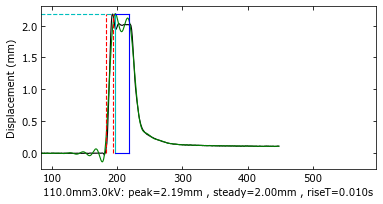

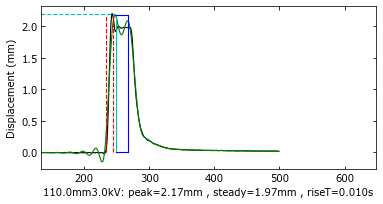

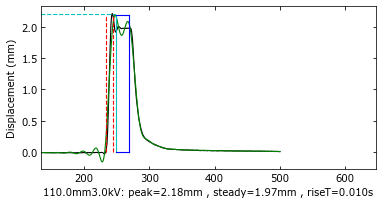

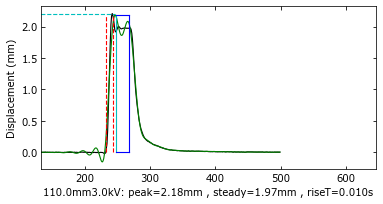

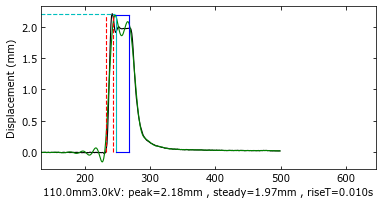

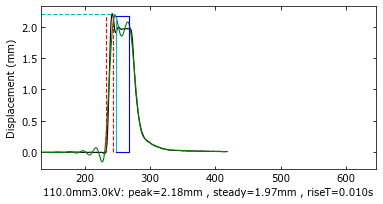

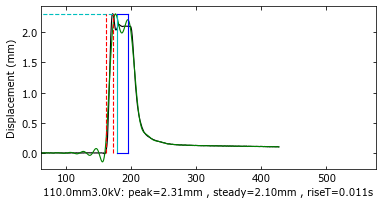

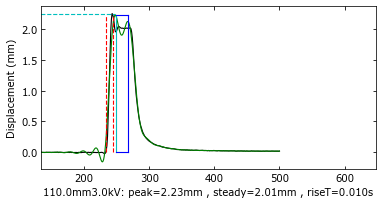

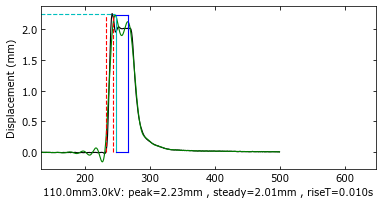

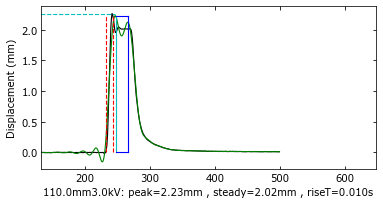

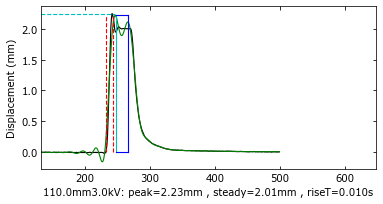

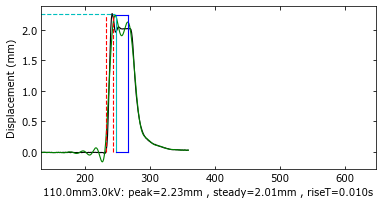

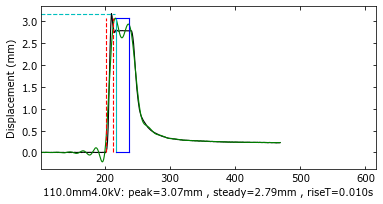

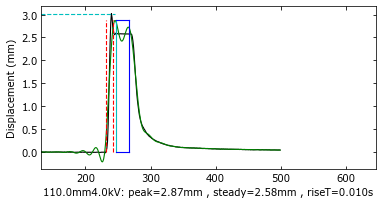

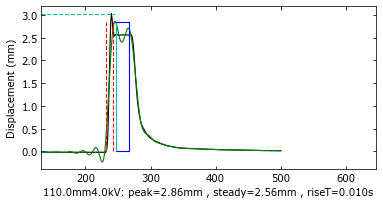

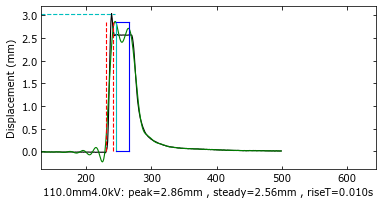

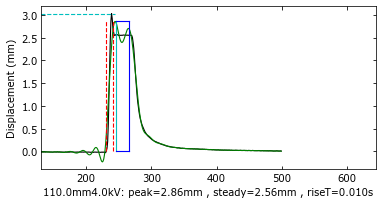

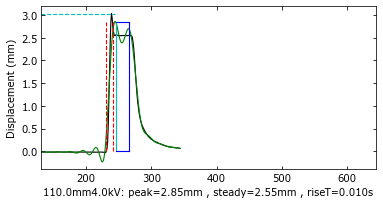

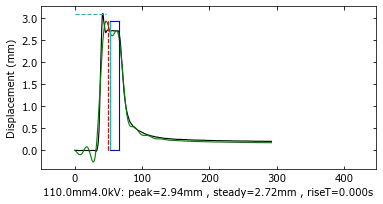

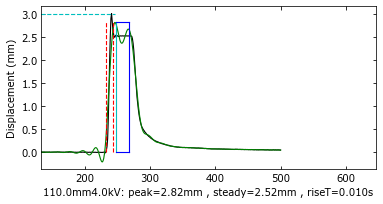

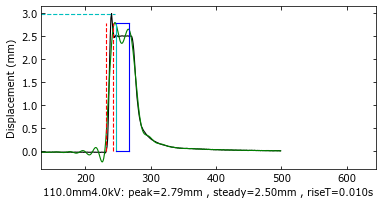

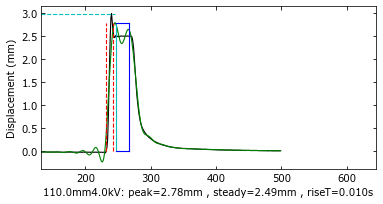

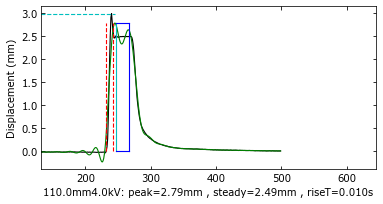

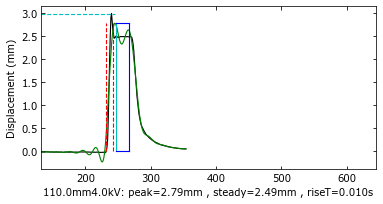

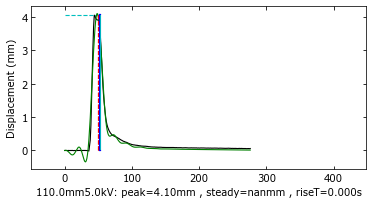

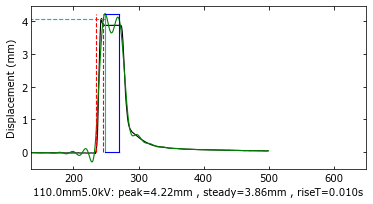

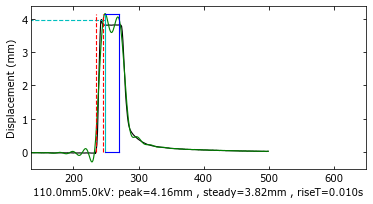

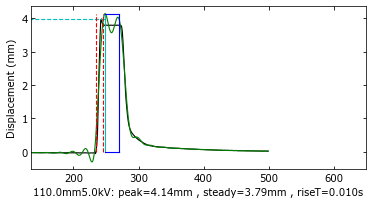

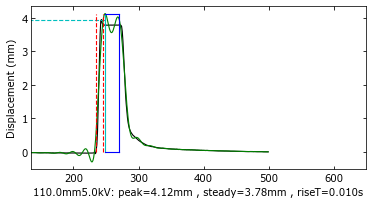

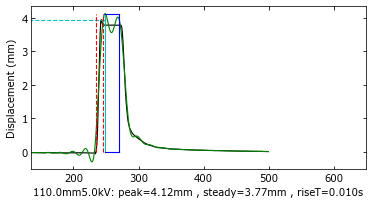

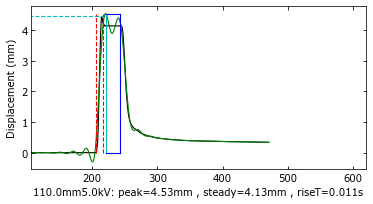

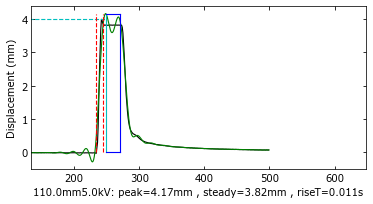

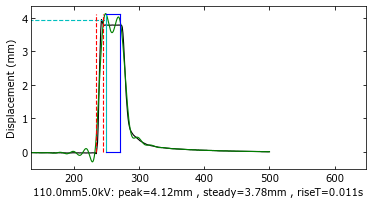

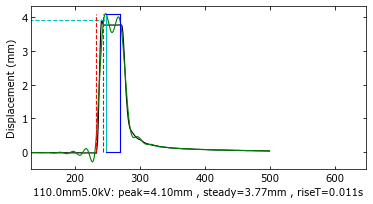

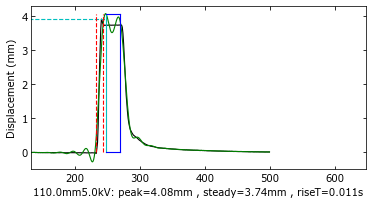

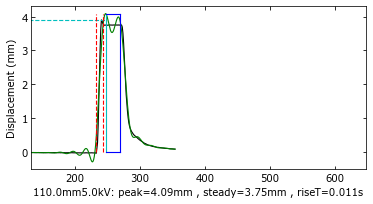

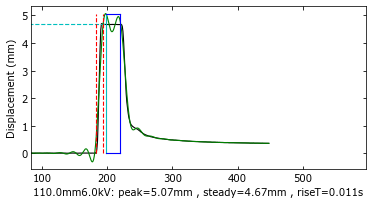

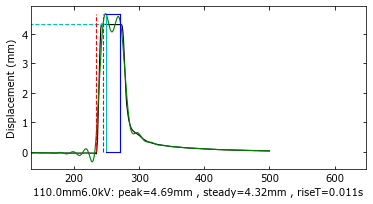

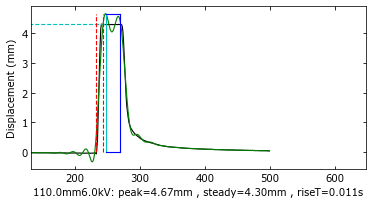

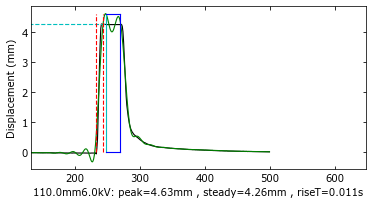

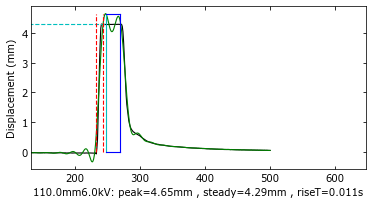

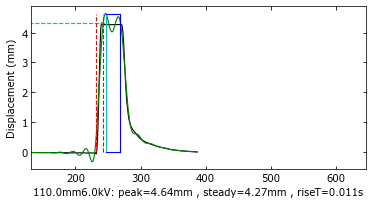

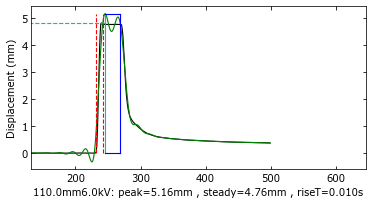

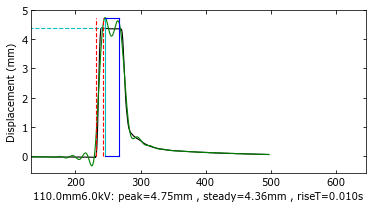

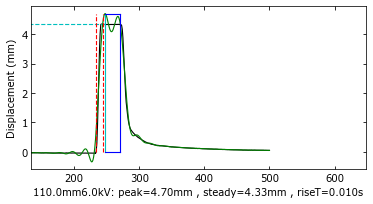

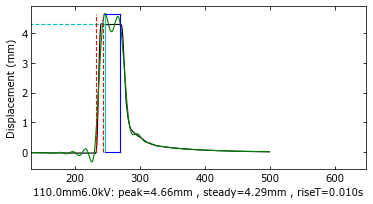

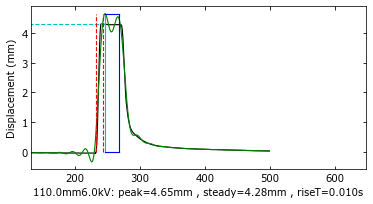

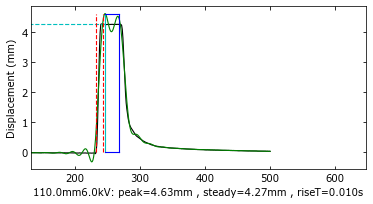

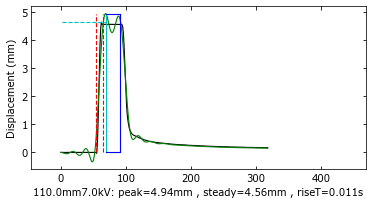

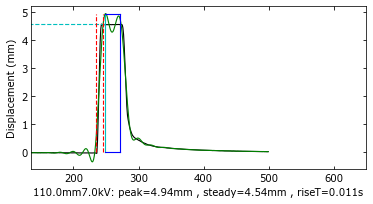

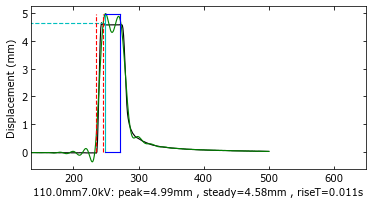

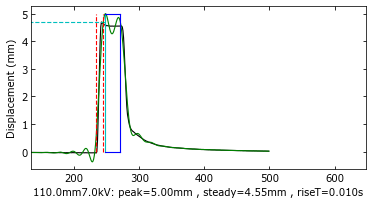

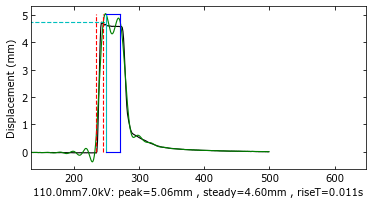

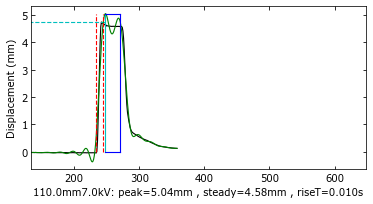

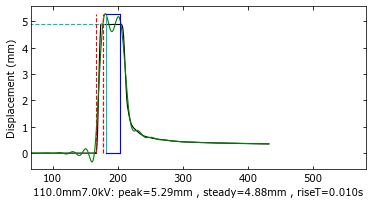

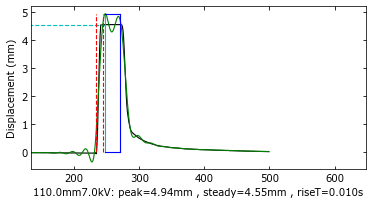

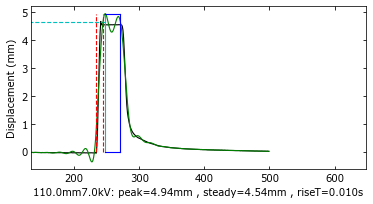

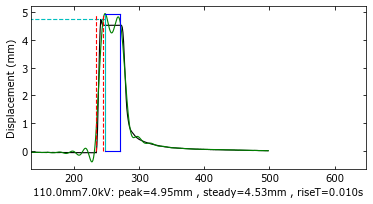

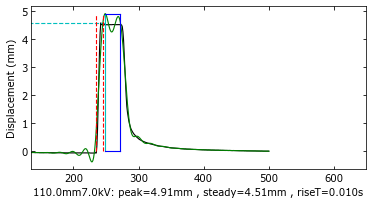

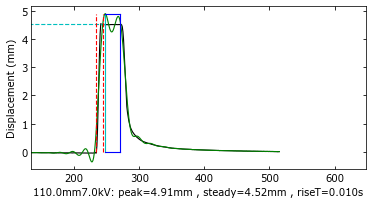

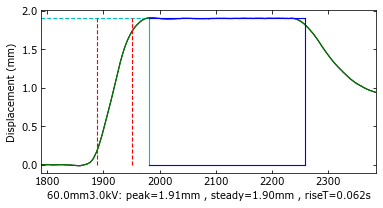

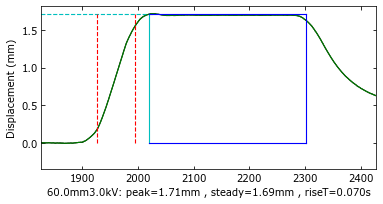

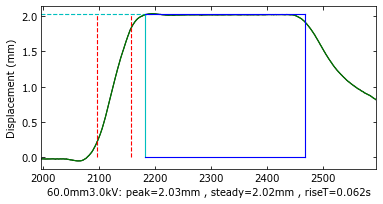

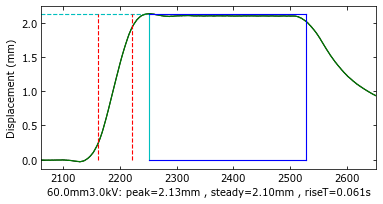

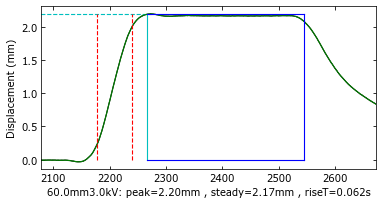

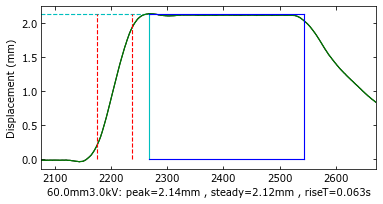

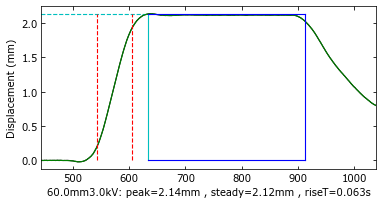

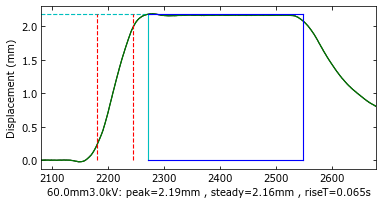

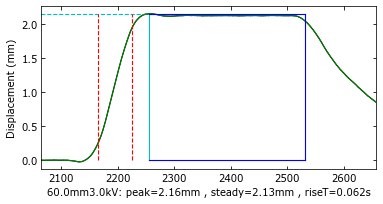

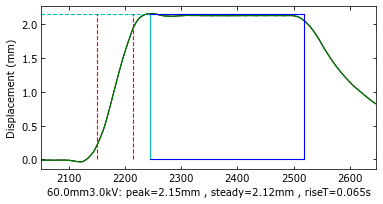

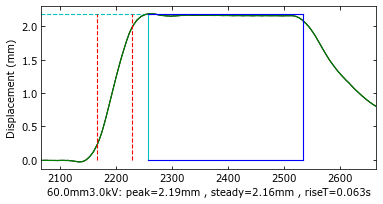

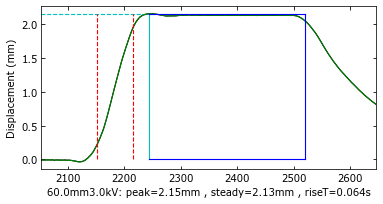

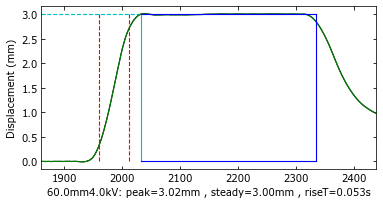

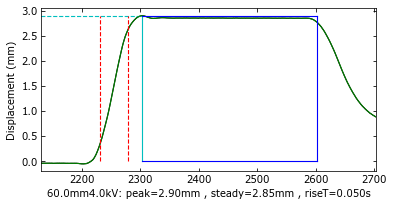

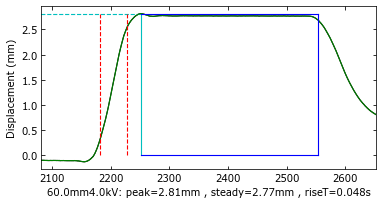

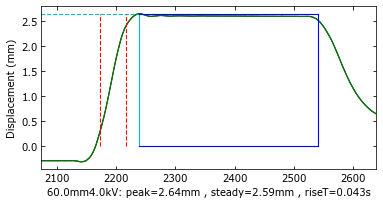

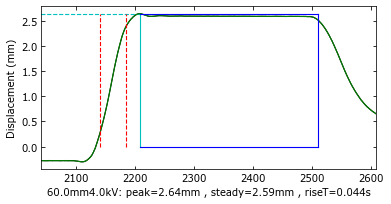

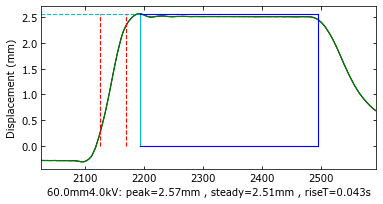

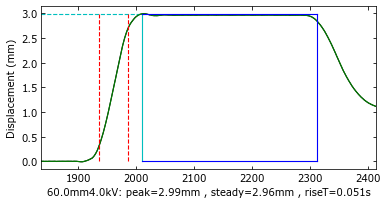

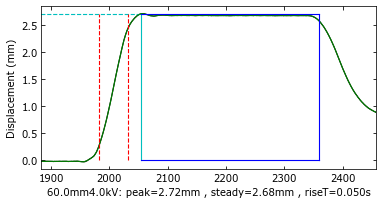

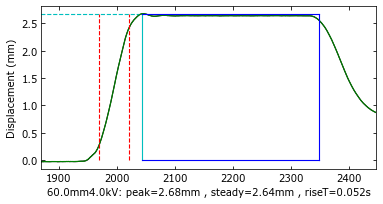

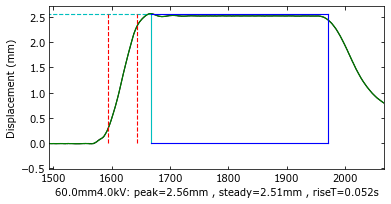

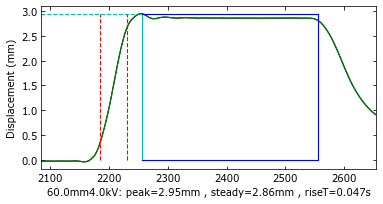

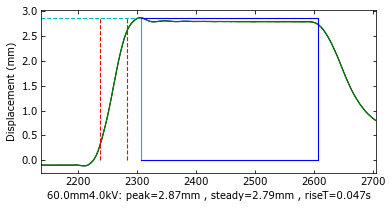

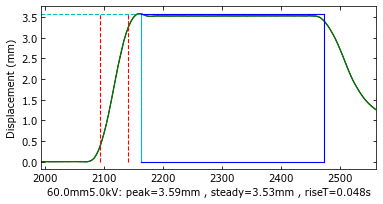

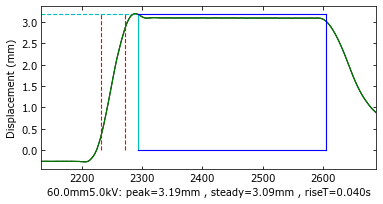

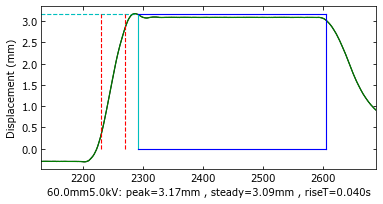

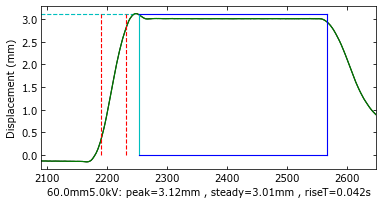

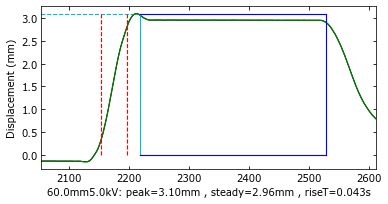

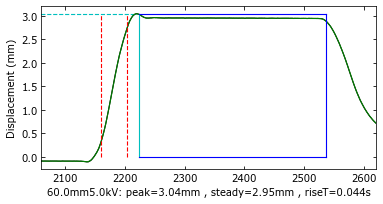

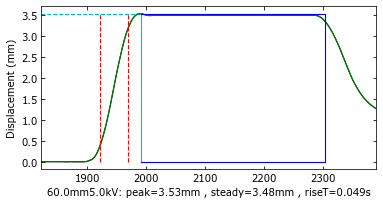

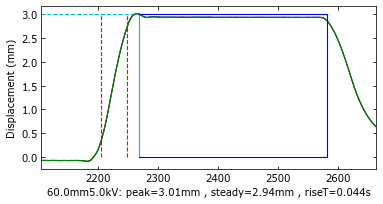

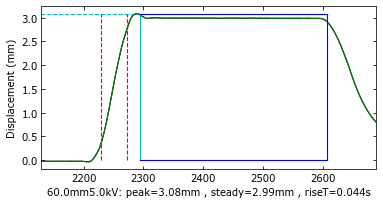

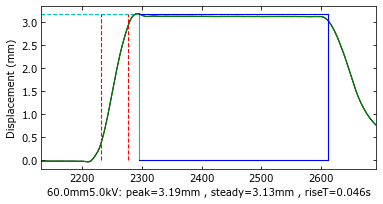

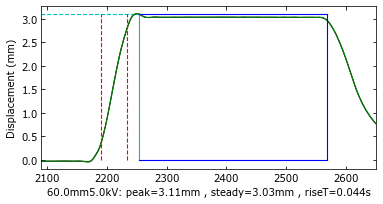

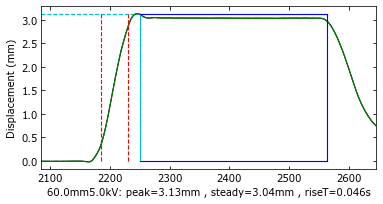

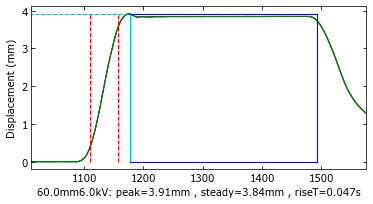

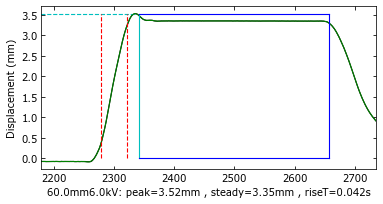

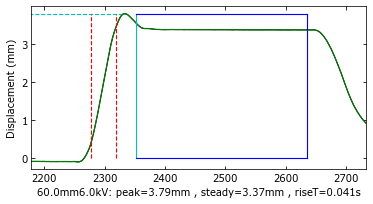

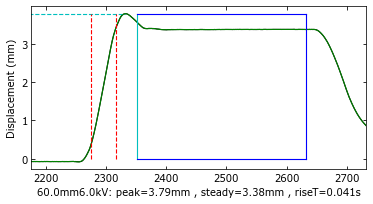

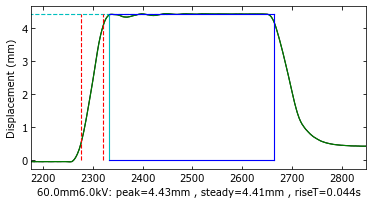

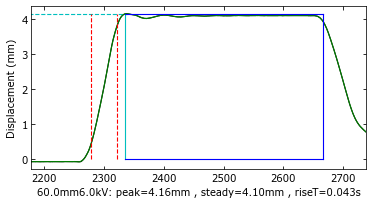

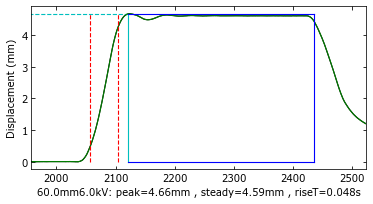

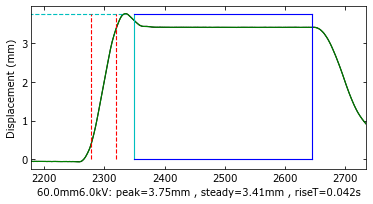

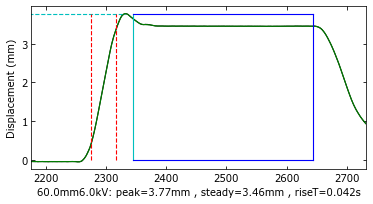

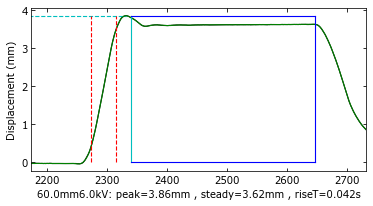

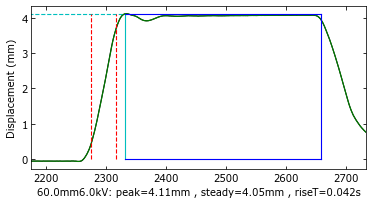

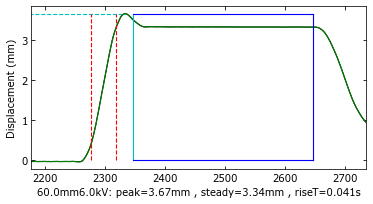

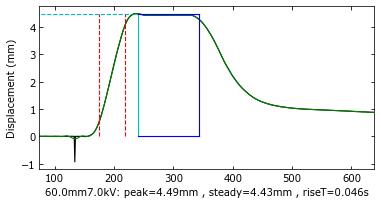

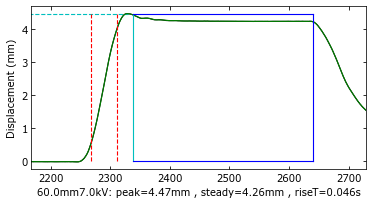

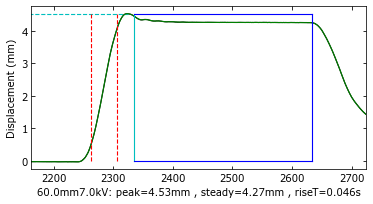

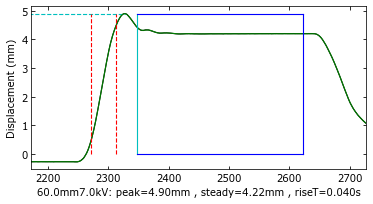

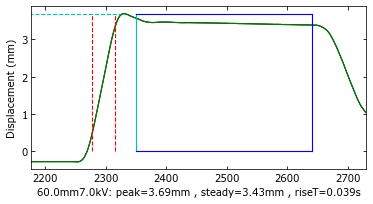

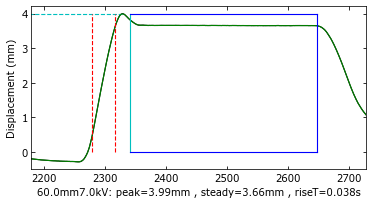

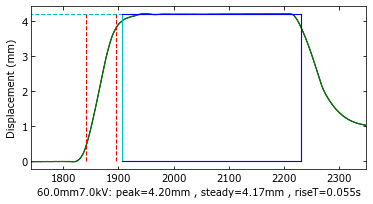

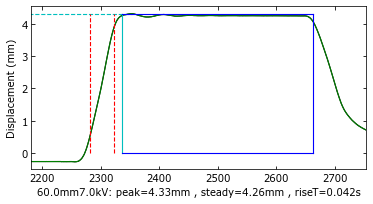

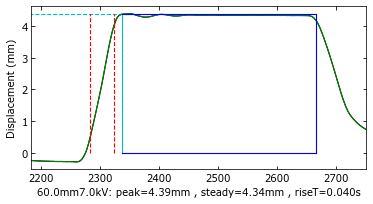

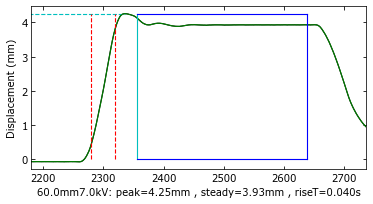

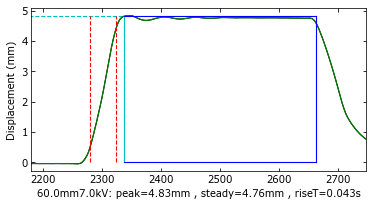

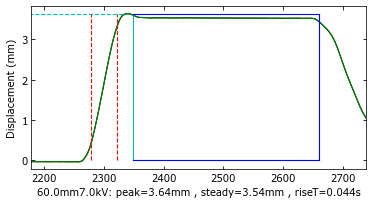

,Label,TubeLength_mm,Voltage_kV,PeakForce,RawPeakForce,steadyRawForce,TriseForce,Data
0,110.0mm3.0kV,110.0,3.0,"[2.186890849614473, 2.174690414660549, 2.18232...","[2.1799, 2.1979, 2.2069, 2.2049000000000003, 2...","[2.003504761904762, 2.003504761904762, 1.97401...","[0.010111223458038422, 0.010111223458038422, 0...","[[0.0, -0.0003479825857874985, -0.000685412412..."
1,110.0mm4.0kV,110.0,4.0,"[3.0731661989558425, 2.871731966696956, 2.8568...","[3.176, 3.0221, 3.0303, 3.0336, 3.029299999999...","[2.7854349999999997, 2.7854349999999997, 2.579...","[0.010111223458038422, 0.010111223458038422, 0...","[[0.0, 0.0005922921805390224, 0.00115578665906..."
2,110.0mm5.0kV,110.0,5.0,"[4.095083540267144, 4.219703196773291, 4.16135...","[4.0482, 4.0682, 3.9843, 3.9771, 3.94420000000...","[nan, nan, 3.8628619047619046, 3.8628619047619...","[0.0, 0.010111223458038422, 0.0101112234580384...","[[0.0, 0.004829727103227821, 0.004753526898362..."
3,110.0mm6.0kV,110.0,6.0,"[5.067577080929387, 4.692126423509852, 4.66612...","[4.7036999999999995, 4.3368, 4.3127, 4.2832, 4...","[4.673114285714286, 4.673114285714286, 4.32038...","[0.011122345803842264, 0.011122345803842264, 0...","[[0.0, 0.00016743344973857432, 0.0003425641435..."
4,110.0mm7.0kV,110.0,7.0,"[4.940721874586429, 4.935325726416165, 4.98788...","[4.638199999999999, 4.5636, 4.657, 4.6977, 4.7...","[4.557277272727273, 4.557277272727273, 4.54322...","[0.011122345803842264, 0.011122345803842264, 0...","[[0.0, -0.003984931418511639, -0.0098054747192..."
5,60.0mm3.0kV,60.0,3.0,"[1.9086416774095825, 1.7091676587236695, 2.032...","[1.9095, 1.7093000000000003, 2.0334, 2.1334, 2...","[1.8977478417266187, 1.8977478417266187, 1.689...","[0.06167846309403438, 0.06976744186046512, 0.0...","[[0.0, -0.00010841949437485291, -0.00020280087..."
6,60.0mm4.0kV,60.0,4.0,"[3.016488527489606, 2.8961930449231237, 2.8129...","[3.0155, 2.8958, 2.813, 2.6384000000000003, 2....","[3.0010857142857144, 3.0010857142857144, 2.849...","[0.0525783619817998, 0.04954499494438827, 0.04...","[[0.0, 0.00025701320394786765, 0.0004933648793..."
7,60.0mm5.0kV,60.0,5.0,"[3.5854350954993808, 3.191436166282619, 3.1747...","[3.5859, 3.1895, 3.171, 3.1155, 3.0914, 3.0431...","[3.5285229773462783, 3.5285229773462783, 3.091...","[0.047522750252780584, 0.04044489383215369, 0....","[[0.0, 0.0004074238953099803, 0.00079979046440..."
8,60.0mm6.0kV,60.0,6.0,"[3.911344090384345, 3.524083586239149, 3.78565...","[3.9118, 3.5191, 3.7822000000000005, 3.7818999...","[3.841472784810127, 3.841472784810127, 3.34725...","[0.046511627906976744, 0.042467138523761376, 0...","[[0.0, -0.0002768437134495613, -0.000551252195..."
9,60.0mm7.0kV,60.0,7.0,"[4.491512939817192, 4.472194695614767, 4.52962...","[4.4914, 4.470599999999999, 4.5259, 4.9007, 3....","[4.42824854368932, 4.42824854368932, 4.2567438...","[0.0455005055611729, 0.0455005055611729, 0.045...","[[0.0, -0.00045196898417639714, -0.00088552437..."


In [10]:
'''
Pulse train measurements:

Feature extraction from signals: peak value, time-averaged value, rising time
'''

measureDataPath = './DispData20221212Voltage' # 60mm and 110mm
laserData, Fs = dataSegmentation(measureDataPath)

labels = laserData.Label.unique()
print(labels)

dataFeature = []

for aLabel in labels:
    selectedData = laserData.loc[(laserData['Label'] == aLabel)]

    peakF = []
    rawPeakF = []
#     tavgF = []
    steadyRawF = []
    triseF = []
    smF = []
        
    for index, row in selectedData.iterrows():
        for aSignal in row["Data"]:
            smData = lowpassSmooth(aSignal, cutFreqRatio = (50/Fs), order = 10)
            smData = smData - smData[0]

            maxValue = np.max(smData)
            onsetInd = np.argwhere(smData[50:] > 0.10 * maxValue)[0][0]+50 # When signal reach 10% of its peak (onset)

            PTopInd = np.argwhere(smData[50:] > 0.90 * maxValue)[0][0]+50 # When signal reach 90% of its peak
            
            ''' To Find the steady state force '''
            offInd = np.argwhere(smData[50:] > 0.80 * maxValue)[-1][0]+50
            if(offInd == None or offInd < PTopInd):
                offInd = smData.shape[0]
                
            leftInd = PTopInd
            RightInd = offInd
            while(leftInd < RightInd and abs(smData[leftInd] - smData[RightInd]) > (0.05*maxValue)):
                leftInd = leftInd+1
                RightInd = RightInd-1
                

            peakInd = np.argmax(smData)
            peakValue = np.max(smData)           
            rawPeakValue = np.max(aSignal[:peakInd]-aSignal[0])

            riseTime = (PTopInd - onsetInd)/Fs
            
            steadyRawValue = np.mean(aSignal[leftInd:RightInd]-aSignal[0]) # steady takes mean during steady state
            steadyRawF.append(steadyRawValue)
            
#             tavgValue = np.mean(smData[onsetInd:PTopInd]) 
            
            peakF.append(peakValue)
            rawPeakF.append(rawPeakValue)
#             tavgF.append(tavgValue)
            steadyRawF.append(steadyRawValue)
            triseF.append(riseTime)
            smF.append(smData)
            
            ax1,_ = aPlot(dpi=72)
            ax1.plot(aSignal-aSignal[0], 'k')
#             ax1.plot([1, peakInd], [peakValue, peakValue], '--b')
            ax1.plot([1, peakInd], [rawPeakValue, rawPeakValue], '--c')
            ax1.plot(smData, 'g')
            ax1.plot([onsetInd, onsetInd], [0, maxValue], '--r')
            ax1.plot([PTopInd, PTopInd], [0, maxValue], '--r')
            
            ax1.plot([leftInd, leftInd], [0, maxValue], '-c')
            ax1.plot([RightInd, RightInd], [0, maxValue], '-b')
            ax1.plot([leftInd, RightInd], [0, 0], '-b')
            ax1.plot([leftInd, RightInd], [maxValue, maxValue], '-b')
            
            ax1.set_xlabel("%s: peak=%.2fmm , steady=%.2fmm , riseT=%.3fs" % (aLabel, peakValue,steadyRawValue,riseTime))
            ax1.set_xlim([onsetInd-100, peakInd + 400])
            ax1.set_ylabel("Displacement (mm)")
            plt.show()
            
    dataFeature.append([aLabel, row["TubeLength_mm"], row["Voltage_kV"], peakF, rawPeakF, steadyRawF, triseF, smF])

dataFeature = pd.DataFrame(dataFeature, columns = ['Label', 'TubeLength_mm','Voltage_kV','PeakForce','RawPeakForce',
                                                   'steadyRawForce','TriseForce','Data'])  

dataFeature.head(10)

In [5]:
'''
Functions for Computing and Visualizing Errorbar
'''
def computeErrorbar1Var(dframe, xColName, xColList, zColName):
    dMean = []
    dSTD = []
    
    for x in xColList:
        selectInd = (dframe[xColName] == x)

        compValue = getDataArray(dframe, selectInd, zColName, toFlat=True)  

        valueMean, valueSTD = getMeanSTD(compValue)

        dMean.append(valueMean)
        dSTD.append(valueSTD)
    
    dMean = np.array(dMean)
    dSTD = np.array(dSTD)
    
    return dMean, dSTD

def computeErrorbar(dframe, xColName, xColList, yColName, yColList, zColName):
    dMean = []
    dSTD = []
    
    for x in xColList:
        dMean.append([])
        dSTD.append([])
        for y in yColList:
            selectInd = (dframe[xColName] == x) & (dframe[yColName] == y)

            compValue = getDataArray(dframe, selectInd, zColName, toFlat=True)  
            
            valueMean, valueSTD = getMeanSTD(compValue)
            
            dMean[-1].append(valueMean)
            dSTD[-1].append(valueSTD)
    
    dMean = np.array(dMean)
    dSTD = np.array(dSTD)
    
    return dMean, dSTD

def dispErrorbar(ax, x, dMean, dErr, xLabel, xLabelStr, yLabelStr, zLabel, colors=['C1'], style='.-', 
                 dispLegend=True, xShift=[0.1,0.4]):
    yLen = len(yLabelStr)
    
    ax.set_ylabel(zLabel, color='k')
    ax.tick_params(axis='y', labelcolor='k')
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k') 
    ax.spines['right'].set_color('k')
    ax.spines['left'].set_color('k')

    pltHandles = []
    for i in np.arange(yLen):
        pltHandles.append(ax.plot(2*x + (i * xShift[0]), dMean[i], style, c=colors[i])[0])
        (ax.errorbar(2*x + (i * xShift[0]), dMean[i], yerr=dErr[i], fmt='none', ecolor=colors[i], capsize=0)[0]) 
        
    ax.set_xlabel(xLabel)
    ax.set_xticklabels(xLabelStr, rotation=0);
    ax.set_xticks(2*x + xShift[1]);

    if dispLegend:
        ax.legend(handles=reversed(pltHandles), labels=reversed(yLabelStr), frameon=False, bbox_to_anchor=(1.02, 1.0), 
                  loc='upper left');
    
    return ax

Raw Displacement - Mean (n=12, 60mm/110mm)
60mm: [2.09194167 2.777375   3.18529167 3.95095833 4.30928333] 
110mm: [2.23435833 3.03214167 4.00590833 4.39436667 4.66715   ]
Raw Displacement - STD (n=12, 60mm/110mm)
60mm: [0.13872248 0.15830856 0.1738552  0.31897323 0.37504136] 
110mm: [0.03610063 0.05459582 0.13923362 0.16845218 0.09748511]

 ----- Mixed data  ----- 
Raw Displacement - Mean (n=12, 60mm + 110mm):
[2.23435833 3.03214167 4.00590833 4.39436667 4.66715   ]
Raw Displacement - STD (n=12, 60mm + 110mm):
[0.03610063 0.05459582 0.13923362 0.16845218 0.09748511]
Steady State Raw force - Mean (n=12, 110mm):
[2.00266258 2.56750317        nan 4.36796888 4.57877046]
Steady State Raw force - STD (n=12, 110mm):
[0.03557036 0.08900509        nan 0.16012382 0.09308429]

 ----- Data (n=12, 110mm) ----- 
Force Rise Time - Mean (n=12, 110mm):
[0.01019548 0.00926862 0.00977418 0.01061678 0.01044826]
Force Rise Time - STD (n=12, 110mm):
[0.00027946 0.00279459 0.00298619 0.00050556 0.00047665]


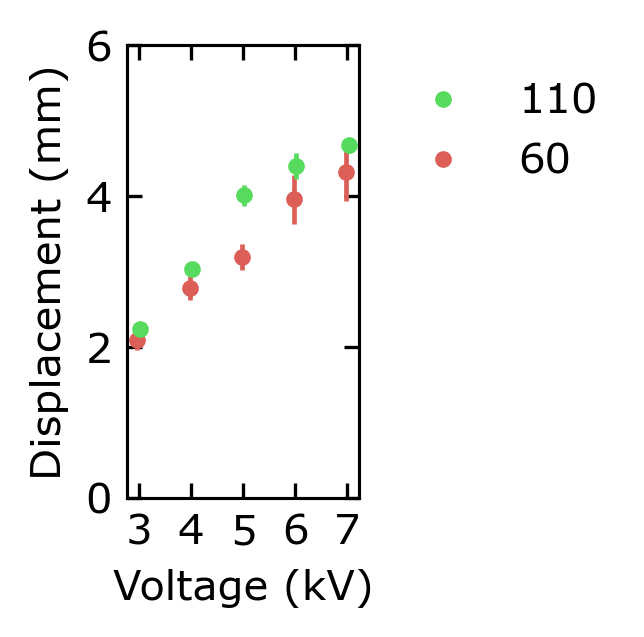

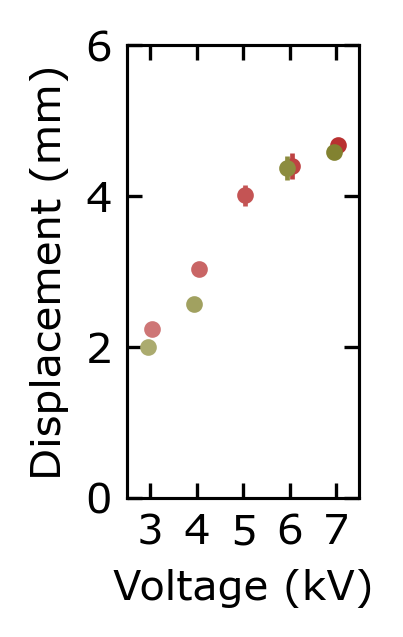

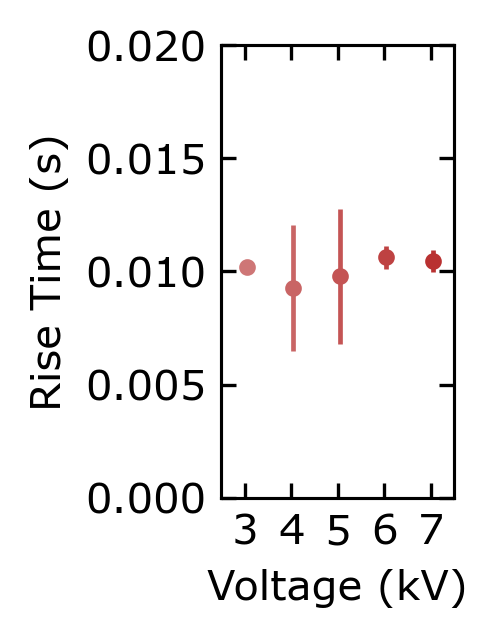

In [12]:
'''
Analysis for Visualizing the Errorbar of multiple actuator types
'''
# labels = ['60mm3.0kV', '60mm4.0kV', '60mm5.0kV', '60mm6.0kV', '60mm7.0kV',
#           '110mm3.0kV', '110mm4.0kV', '110mm5.0kV', '110mm6.0kV', '110mm7.0kV']

vLevels = [3, 4, 5, 6, 7]
tLengths = [60, 110]

colors = sns.color_palette('hls', n_colors=3)
style = '.'

xLen = len(vLevels)
x = np.arange(xLen)
xLabelStr = np.array(vLevels)
yLabelStr = tLengths
xLabel = 'Voltage (kV)'

meanPeakPdc, stdPeakPdc = computeErrorbar(dataFeature, 'TubeLength_mm', tLengths, 'Voltage_kV', vLevels, 'PeakForce')   
meanRawPeakF, stdRawPeakF = computeErrorbar(dataFeature, 'TubeLength_mm', tLengths, 'Voltage_kV', vLevels, 'RawPeakForce')

print("Raw Displacement - Mean (n=12, 60mm/110mm)")
print("60mm: %s \n110mm: %s" % (meanRawPeakF[0], meanRawPeakF[1]))
print("Raw Displacement - STD (n=12, 60mm/110mm)")
print("60mm: %s \n110mm: %s" % (stdRawPeakF[0], stdRawPeakF[1]))

fig1, ax1 = plt.subplots(dpi=300, figsize=(1,2))

dispErrorbar(ax1, x, meanRawPeakF, stdRawPeakF, xLabel, xLabelStr, yLabelStr, 'Displacement (mm)', colors, style=style,
            xShift=[0.1,0.05])

ax1.set_ylim([0, 6])

# fig1.savefig("displace_voltage_60and110.pdf", bbox_inches='tight')


#'''Average of two actuators'''
''' Actuator 110mm '''
dataFeature110 = dataFeature.loc[(dataFeature['TubeLength_mm'] == 110)]
meanRawPeakF, stdRawPeakF = computeErrorbar1Var(dataFeature110, 'Voltage_kV', vLevels, 'RawPeakForce')
meanSteadyRawF, stdSteadyRawF = computeErrorbar1Var(dataFeature110, 'Voltage_kV', vLevels, 'steadyRawForce')

print("\n ----- Mixed data  ----- ")
print("Raw Displacement - Mean (n=12, 60mm + 110mm):")
print(meanRawPeakF)
print("Raw Displacement - STD (n=12, 60mm + 110mm):")
print(stdRawPeakF)

print("Steady State Raw force - Mean (n=12, 110mm):")
print(meanSteadyRawF)
print("Steady State Raw force - STD (n=12, 110mm):")
print(stdSteadyRawF)

fig2, ax2 = plt.subplots(dpi=300, figsize=(1,2))    

colors = sns.light_palette(pltRed, reverse=True, n_colors=(xLen+8)) # Red for peak values
colors2 = sns.light_palette(pltYellow, reverse=True, n_colors=(xLen+8)) # Yellow for steady state values

for i in range(xLen):
    ax2.plot(vLevels[i]+0.05, meanRawPeakF[i], '.', c=colors[xLen-i])
    ax2.errorbar(vLevels[i]+0.05, meanRawPeakF[i], yerr=stdRawPeakF[i], fmt='none', ecolor=colors[xLen-i], capsize=0)
    
    ax2.plot(vLevels[i]-0.05, meanSteadyRawF[i], '.', c=colors2[xLen-i])
    ax2.errorbar(vLevels[i]-0.05, meanSteadyRawF[i], yerr=stdSteadyRawF[i], fmt='none', ecolor=colors2[xLen-i], capsize=0)

ax2.set_ylabel('Displacement (mm)')
ax2.set_xlabel(xLabel)
ax2.set_xticks(vLevels);

ax2.set_xlim([vLevels[0]-0.5, vLevels[-1]+0.5])
ax2.set_ylim([0, 6])

fig2.savefig("displace_voltage_110mm.pdf", bbox_inches='tight')

''' Rise Time '''
meanRiseTime, stdRiseTime = computeErrorbar1Var(dataFeature110, 'Voltage_kV', vLevels, 'TriseForce')
print("\n ----- Data (n=12, 110mm) ----- ")
print("Force Rise Time - Mean (n=12, 110mm):")
print(meanRiseTime)
print("Force Rise Time - STD (n=12, 110mm):")
print(stdRiseTime)

fig3, ax3 = plt.subplots(dpi=300, figsize=(1,2))  
for i in range(xLen):
    ax3.plot(vLevels[i]+0.05, meanRiseTime[i], '.', c=colors[xLen-i])
    ax3.errorbar(vLevels[i]+0.05, meanRiseTime[i], yerr=stdRiseTime[i], fmt='none', ecolor=colors[xLen-i], capsize=0)
    
ax3.set_ylabel('Rise Time (s)')
ax3.set_xlabel(xLabel)
ax3.set_xticks(vLevels);
ax3.set_xlim([vLevels[0]-0.5, vLevels[-1]+0.5])
ax3.set_ylim([0.00, 0.02])
fig3.savefig("displace_riseTime_110mm.pdf", bbox_inches='tight')

In [ ]:
'''Plot signal waveform of sinusoidal voltage (Vibrometer Measurement)'''
measureDataPath = './VibrometerData20240313Frequency' # 110mm measured on 2024.03.13 with vibrometer (0229)
laserData, Fs = dataVibSegmentation(measureDataPath)

aSignal = laserData.loc[(laserData['Label'] == '110.0mm1.0Hz7.0kV'), 'Data'].values[0][0]

# aSignal2 = laserData.loc[(laserData['Label'] == '110.0mm100.0Hz7.0kV'), 'Data'].values[0][0] # 100Hz
aSignal2 = laserData.loc[(laserData['Label'] == '110.0mm199.5Hz7.0kV'), 'Data'].values[0][0] # 200Hz vibrometer (20240313)
# aSignal2 = laserData.loc[(laserData['Label'] == '110.0mm500.2Hz7.0kV'), 'Data'].values[0][0] # 500Hz

aSignal = aSignal - np.amin(aSignal)
# aSignal2 = aSignal2 - np.mean(aSignal2)

selectColor = pRed # Red for vibrometer and Grey for displ.sensor

fig1, ax = plt.subplots(2,1,dpi=300, figsize=(6,2))
ax[0].plot((np.arange(aSignal.shape[0])/Fs - 0.47) * 1000, aSignal, c=selectColor)
ax[0].set_xlim([1600, 11600]) # setting for 1Hz displ. sensor (20240313)
ax[0].set_ylim([0, 4])
ax[0].set_ylabel('Displacement (mm)')

ax[1].plot((np.arange(aSignal2.shape[0])/Fs) * 1000, aSignal2, c=selectColor)
ax[1].set_xlim([2000, 2100]) # setting for 500Hz vibrometer (20240313)
ax[1].set_ylim([-0.1, 0.1]) # setting for 500Hz vibrometer (20240313)
ax[1].set_xlabel('Time (ms)')

fig1.savefig("Vib_displ_time_sin1sin200.pdf", bbox_inches='tight')

''' Spectrum analysis '''
fig2, ax2 = plt.subplots(2,1,dpi=300, figsize=(1.5,2))
spectr, f, _ = ax2[0].magnitude_spectrum(aSignal-np.mean(aSignal), Fs=Fs, color=selectColor, window=mlab.window_none)
ax2[0].set_xlim([-30, 530])
aSig2 = aSignal2[1000:10000]
aSig2 = signal.detrend(aSig2)
spectr, f, _ = ax2[1].magnitude_spectrum(aSig2-np.mean(aSig2), Fs=Fs, color=selectColor, window=mlab.window_none)
ax2[1].set_xlim([-30, 530])
ax2[1].set_ylim([-0.003, 0.02])
fig2.savefig("Vib_displ_spectrum_110mm.pdf", bbox_inches='tight')

In [ ]:
'''Plot signal waveform of sinusoidal voltage (Laser Displ. Sensor Measurement)'''
# measureDataPath = './DispData20221212Frequency' # 60mm and 110mm
measureDataPath = './DispData20240313Frequency' # 110mm measured on 2024.03.13 with laser displ. sensor
laserData, Fs = dataSegmentation(measureDataPath)

aSignal = laserData.loc[(laserData['Label'] == '110.0mm1.0Hz7.0kV'), 'Data'].values[0][0]
aSignal2 = laserData.loc[(laserData['Label'] == '110.0mm10.0Hz7.0kV'), 'Data'].values[0][0] # 50Hz for displ. data (20240313)
# aSignal2 = laserData.loc[(laserData['Label'] == '110.0mm39.8Hz7.0kV'), 'Data'].values[0][0] # 40Hz for displ. data (old)

aSignal = aSignal - np.amin(aSignal)
# aSignal2 = aSignal2 - np.mean(aSignal2)

selectColor = pGrey # Red for vibrometer and Grey for displ.sensor

fig1, ax = plt.subplots(2,1,dpi=300, figsize=(6,2))
ax[0].plot((np.arange(aSignal.shape[0])/Fs - 0.47) * 1000, aSignal, c=selectColor)
ax[0].set_xlim([1600, 11600]) # setting for 1Hz displ. sensor (20240313)
ax[0].set_ylim([0.7, 3.3])
ax[0].set_ylabel('Displacement (mm)')

ax[1].plot((np.arange(aSignal2.shape[0])/Fs) * 1000, aSignal2, c=selectColor)
ax[1].set_xlim([1000, 2000]) # setting for 10Hz displ. sensor (20240313)
ax[1].set_ylim([1, 2.5]) # setting for 500Hz vibrometer (20240313)
ax[1].set_xlabel('Time (ms)')

fig1.savefig("displ_time_sin1sin10.pdf", bbox_inches='tight')

''' Spectrum analysis '''
fig2, ax2 = plt.subplots(2,1,dpi=300, figsize=(1.5,2))
spectr, f, _ = ax2[0].magnitude_spectrum(aSignal-np.mean(aSignal), Fs=Fs, color=selectColor, window=mlab.window_none)
ax2[0].set_xlim([-30, 530])
ax2[0].set_ylim([-0.03, 0.5]) # setting for 1Hz displ. sensor (20240313)
aSig2 = aSignal2[1000:10000]
aSig2 = signal.detrend(aSig2)
spectr, f, _ = ax2[1].magnitude_spectrum(aSig2-np.mean(aSig2), Fs=Fs, color=selectColor, window=mlab.window_none)
ax2[1].set_xlim([-30, 530])

fig2.savefig("displ_spectrum_110mm.pdf", bbox_inches='tight')

In [ ]:
'''Plot signal waveform of DC voltage'''
aSignal = laserData.loc[(laserData['Label'] == '110.0mm7.0kV'), 'Data'].values[0][0]
aSignal2 = laserData.loc[(laserData['Label'] == '110.0mm3.0kV'), 'Data'].values[0][0]

fig1, ax1 = plt.subplots(dpi=300, figsize=(5,2))

ax1.plot(np.arange(aSignal.shape[0])/Fs, aSignal-aSignal[0], c=colors[0])
ax1.plot(np.arange(aSignal2.shape[0])/Fs-1.3, aSignal2-aSignal2[0], c=colors[xLen])

ax1.set_xlim([0.4, 1.20])
ax1.set_ylim([-0.2, 5])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Displacement (mm)')

ax1.legend(labels=['7kV','3kV'], frameon=False, bbox_to_anchor=(1.0, 0.9), loc='upper left');

fig1.savefig("displ_time_7kv3kv.pdf", bbox_inches='tight')